# Imaging cytometry Cell Cycle
FACED imaging cytometry based biophysical features: MCF7 Cell Cycle

In [1]:
import pyVIA.core as via
import pyVIA.datasets_via as datasets_via
import pandas as pd
import numpy as np
import scanpy as sc     
import umap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-pac

/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/phate/__init__.py


/home/user/anaconda3/envs/Via2Env_py10/lib/python3.10/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


### Load data
Load the data using the function: datasets_via.cell_cycle_cyto_data(foldername='./') OR download the data from [github](https://github.com/ShobiStassen/VIA/tree/master/Datasets) 
The foldername can be changed to the path you want tp save the files for features and labels
the feature matrix and known phase labels. M1 denotes G1 phase, M2 denotes S phase and M3 denotes M/G2 phase

In [5]:
ad = datasets_via.cell_cycle_cyto_data(foldername="/home/user/Trajectory/Datasets/FACED/tests/")

#Download from github datasets
#df=pd.read_csv('/home/user/Trajectory/Datasets/FACED/mcf7_38features.csv')
#df = df.drop('Unnamed: 0', 1)

#true_label = pd.read_csv('/home/user/Trajectory/Datasets/FACED/mcf7_phases.csv')
#true_label = list(true_label['phase'].values.flatten())
#print('There are ', len(true_label), 'MCF7 cells and ', df.shape[1], 'features')
#ad = sc.AnnData(df)
#ad.var_names = df.columns


AnnData object with n_obs × n_vars = 2036 × 38
    obs: 'cell_cycle_phase'


In [6]:
true_label = [i for i in ad.obs['cell_cycle_phase']]


#normalize features
sc.pp.scale(ad)

sc.tl.pca(ad, svd_solver='arpack')
# Weight the top features (ranked by Mutual Information and Random Forest Classifier)
X_in = ad.X
df_X = pd.DataFrame(X_in)

df_X.columns = [i for i in ad.var_names]

df_X['Area'] = df_X['Area'] * 3
df_X['Dry Mass'] = df_X['Dry Mass'] * 3
df_X['Volume'] = df_X['Volume'] * 20

X_in = df_X.values
ad = sc.AnnData(df_X)
#apply PCA
sc.tl.pca(ad, svd_solver='arpack')
ad.var_names = df_X.columns

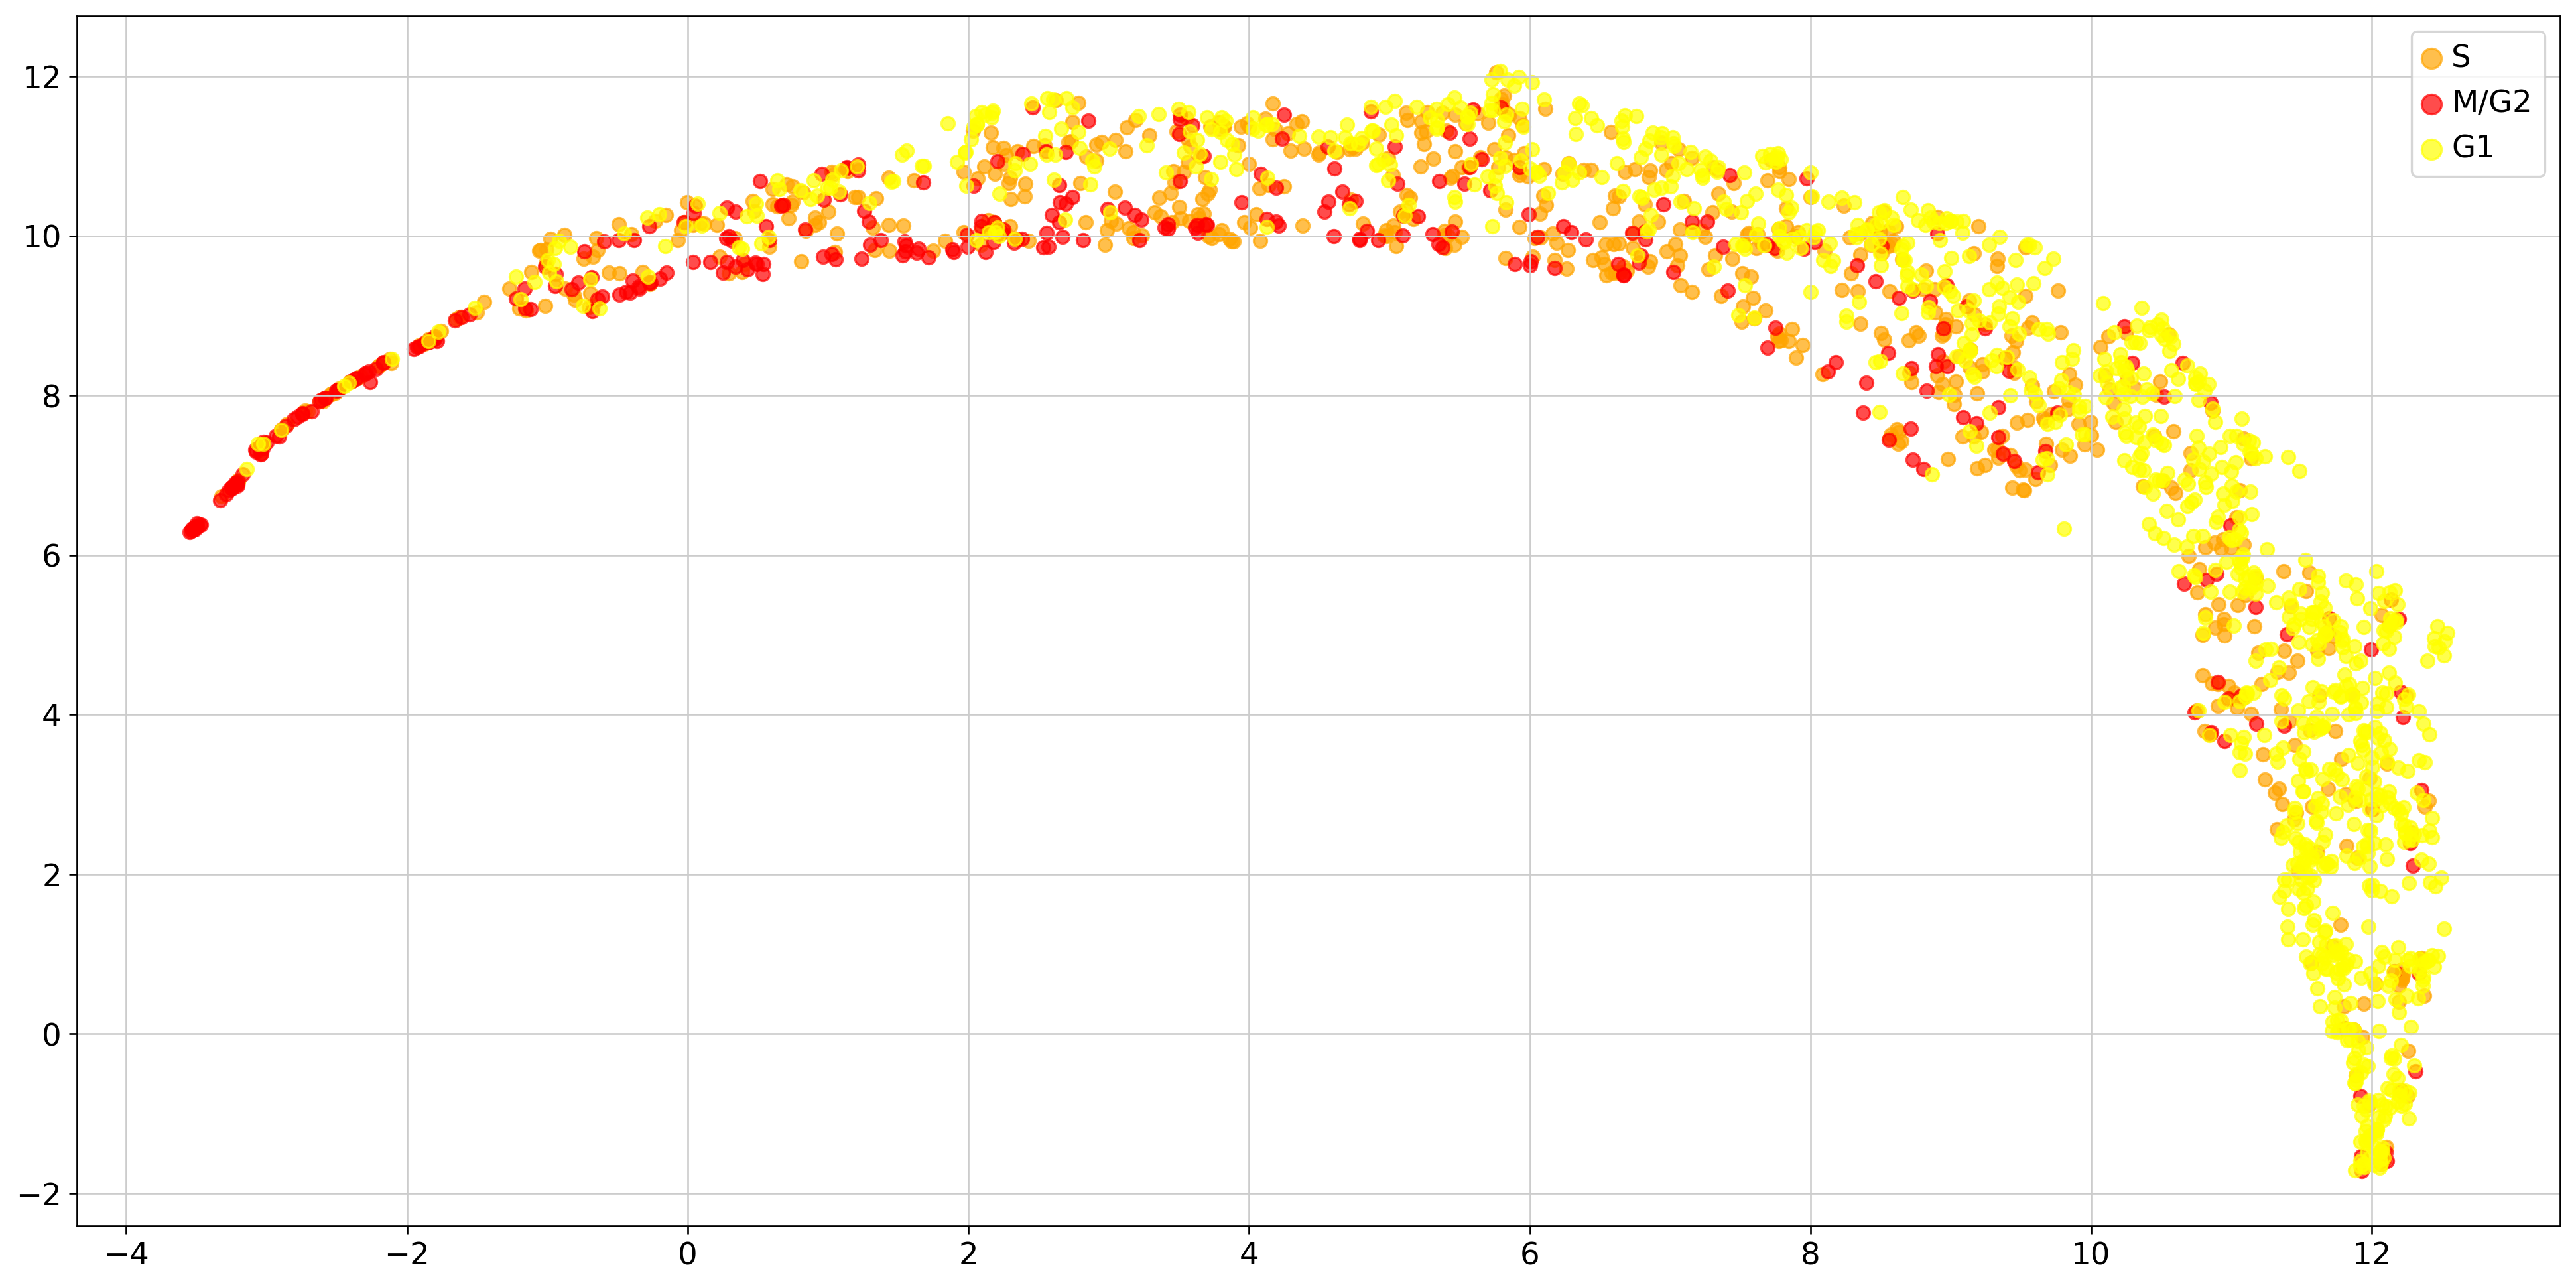

In [5]:
f, ax = plt.subplots(figsize = [20,10])

embedding = umap.UMAP().fit_transform(ad.obsm['X_pca'][:, 0:20])
#phate_op = phate.PHATE()
# embedding = phate_op.fit_transform(X_in)



cell_dict = {'T1_M1': 'yellow', 'T2_M1': 'yellowgreen', 'T1_M2': 'orange', 'T2_M2': 'darkgreen', 'T1_M3': 'red',
             'T2_M3': 'blue'}
cell_phase_dict = {'T1_M1': 'G1', 'T2_M1': 'G1', 'T1_M2': 'S', 'T2_M2': 'S', 'T1_M3': 'M/G2', 'T2_M3': 'M/G2'}

for key in list(set(true_label)):  # ['T1_M1', 'T2_M1','T1_M2', 'T2_M2','T1_M3', 'T2_M3']:
    loc = np.where(np.asarray(true_label) == key)[0]
    ax.scatter(embedding[loc, 0], embedding[loc, 1], c=cell_dict[key], alpha=.7, label=cell_phase_dict[key])
plt.legend(markerscale=1.5, fontsize=14)
plt.show()
true_label = [cell_phase_dict[i] for i in true_label]

### Run VIA

In [7]:
 
knn=20
jac_std_global = 0.5
random_seed = 1
root_user = ['G1']
v0 = via.VIA(X_in, true_label, jac_std_global=jac_std_global, dist_std_local=1, knn=knn,
         too_big_factor=0.3, root_user=root_user, dataset='group', random_seed=random_seed,
          is_coarse=True, preserve_disconnected=True, preserve_disconnected_after_pruning=True,
         pseudotime_threshold_TS=40) 
v0.run_VIA()

2023-09-14 18:10:27.019847	Running VIA over input data of 2036 (samples) x 38 (features)
2023-09-14 18:10:27.019989	Knngraph has 20 neighbors
2023-09-14 18:10:28.166186	Finished global pruning of 20-knn graph used for clustering at level of 0.5. Kept 65.1 % of edges. 
2023-09-14 18:10:28.185627	Number of connected components used for clustergraph  is 1
2023-09-14 18:10:28.301168	Commencing community detection
2023-09-14 18:10:28.335607	Finished running Leiden algorithm. Found 16 clusters.
2023-09-14 18:10:28.337110	Merging 2 very small clusters (<10)
2023-09-14 18:10:28.337692	Finished detecting communities. Found 14 communities
2023-09-14 18:10:28.337854	Making cluster graph. Global cluster graph pruning level: 0.15
2023-09-14 18:10:28.345567	Graph has 1 connected components before pruning
2023-09-14 18:10:28.347815	Graph has 1 connected components after pruning
2023-09-14 18:10:28.348067	Graph has 1 connected components after reconnecting
2023-09-14 18:10:28.348869	0.0% links trimmed

If you would like a finer grained version of VIA to get smaller clusters by 1) increasing the resolution parameter (e.g. to 2), lowering knn or lowering jac_std_global (with typical values between 0-1, with smaller values closer to zero resulting in more small clusters) 

### Visualize output

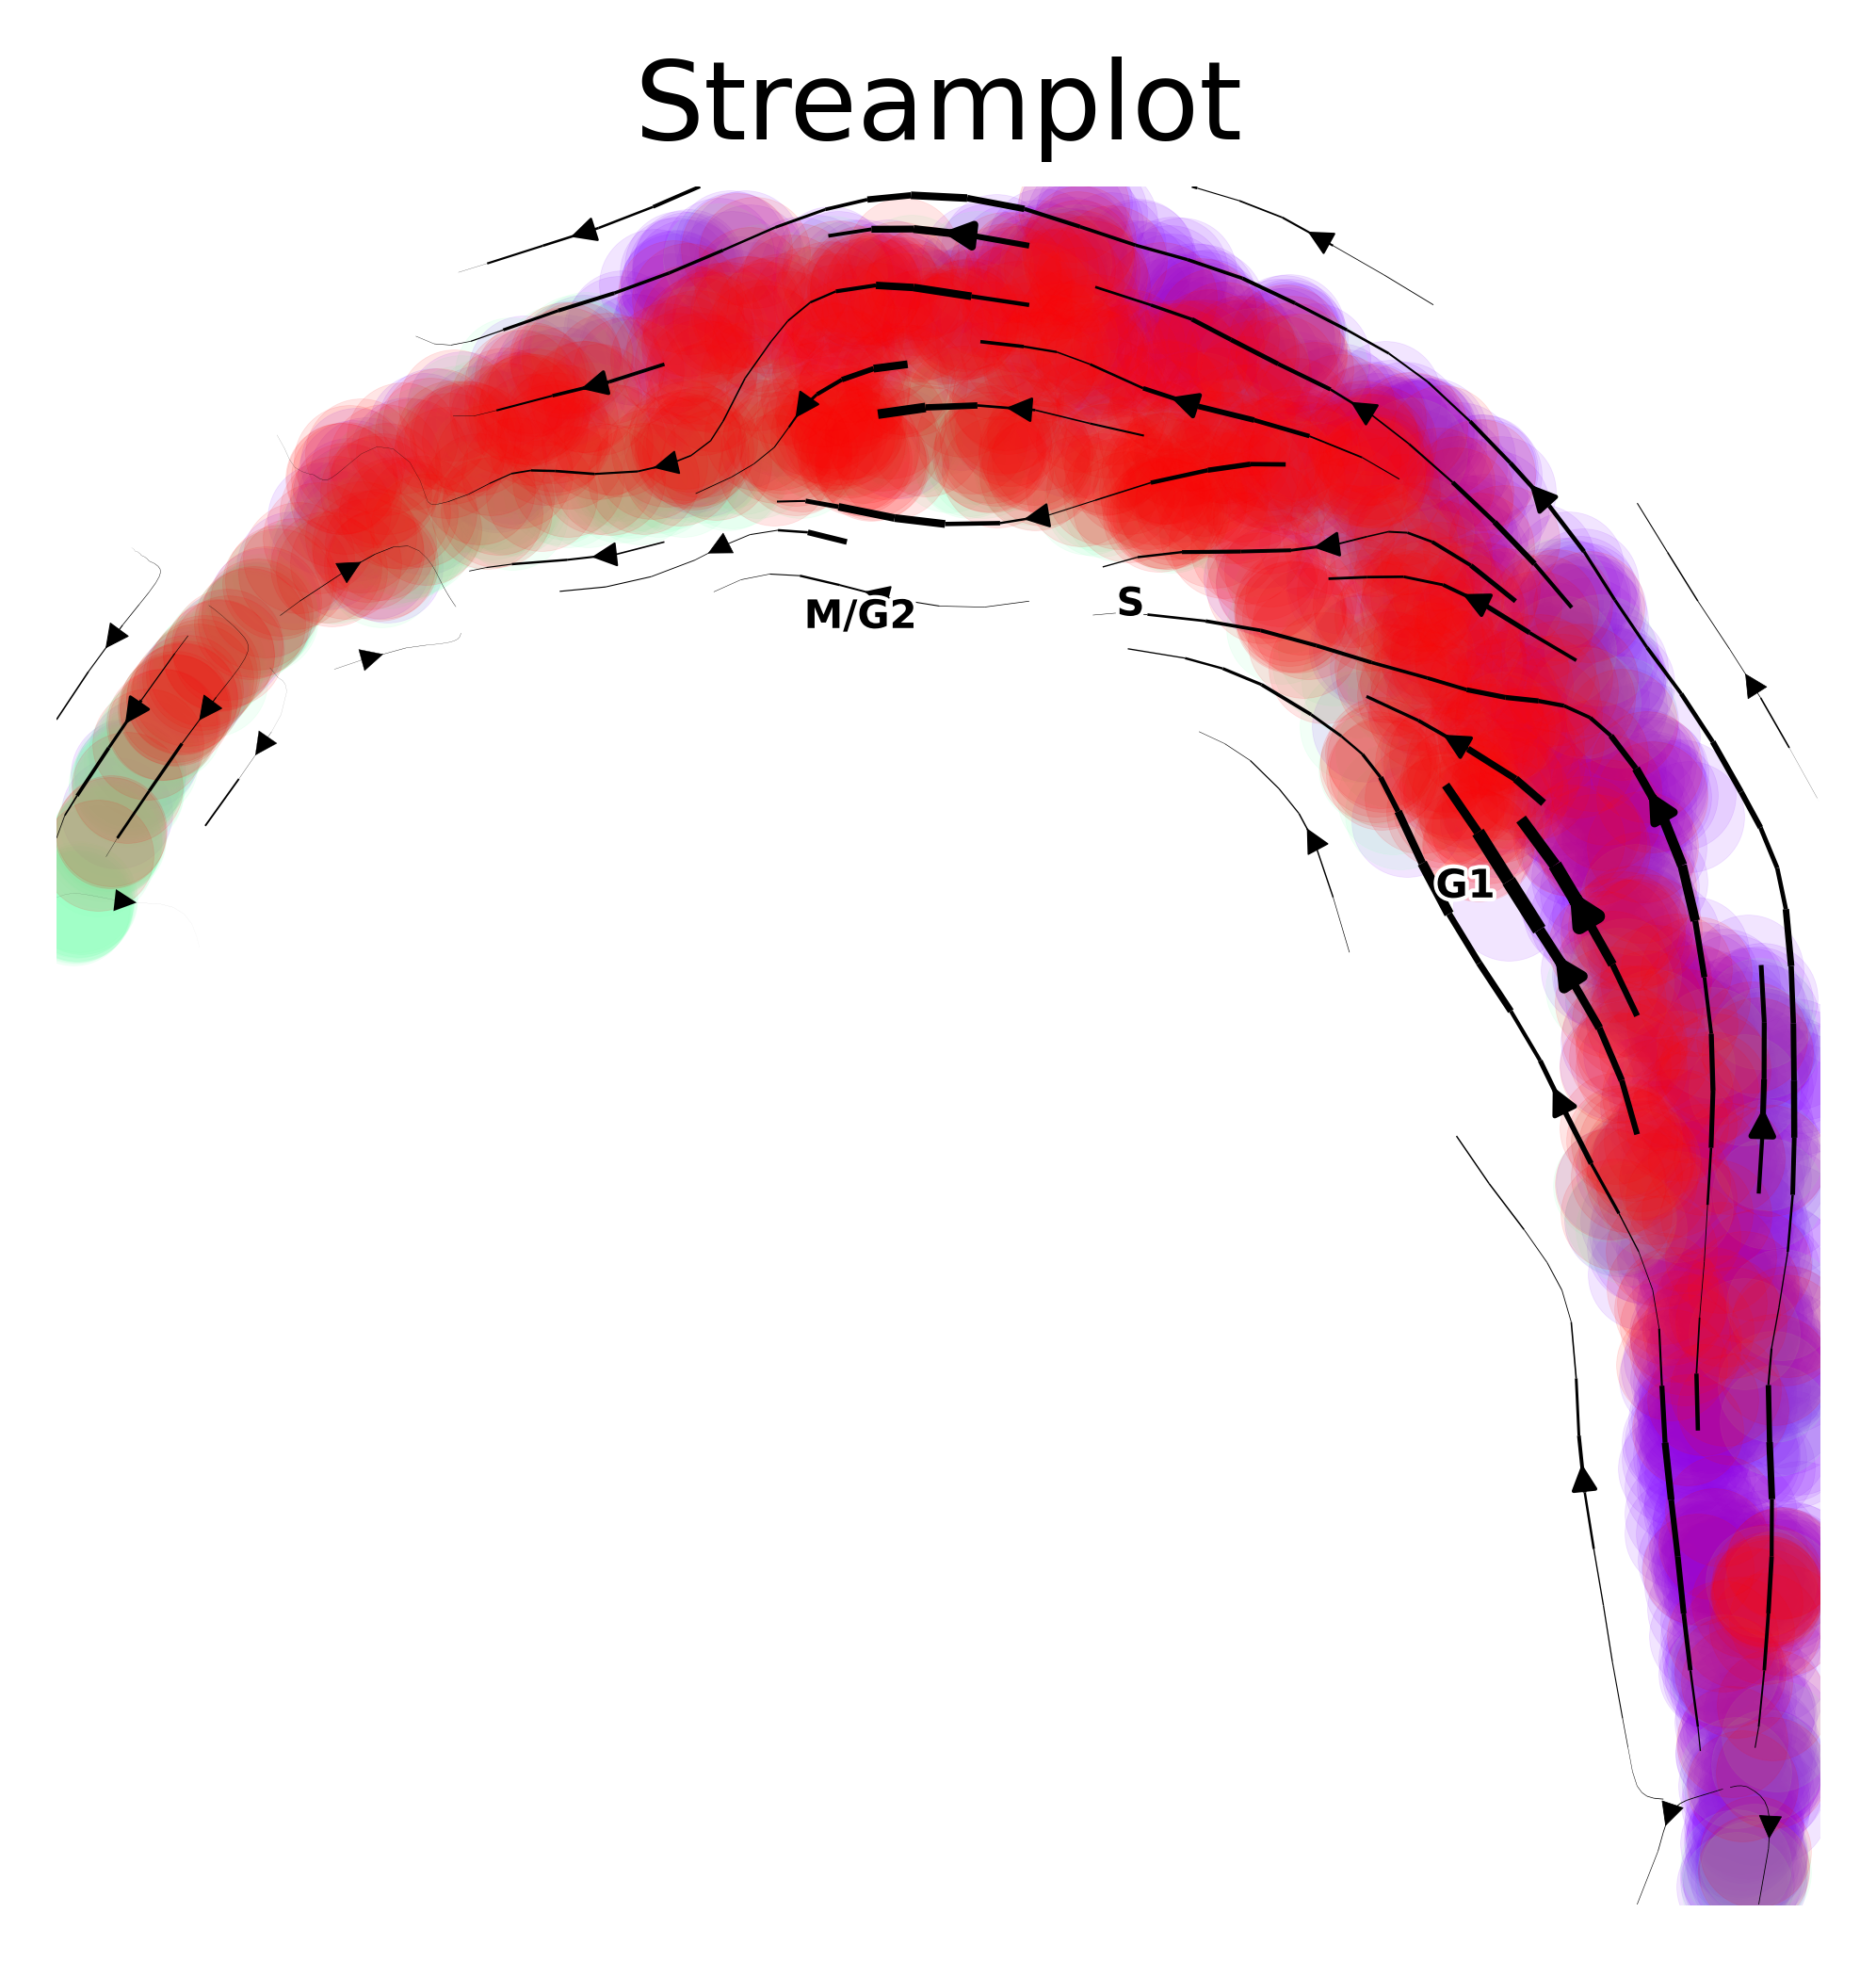

In [8]:
via.via_streamplot(via_object=v0,embedding=embedding, scatter_size=200, scatter_alpha=0.1, density_grid=.5, density_stream=1, smooth_transition=1) #you can choose to use either v1 or v0 as the input for the streamplot
plt.show()

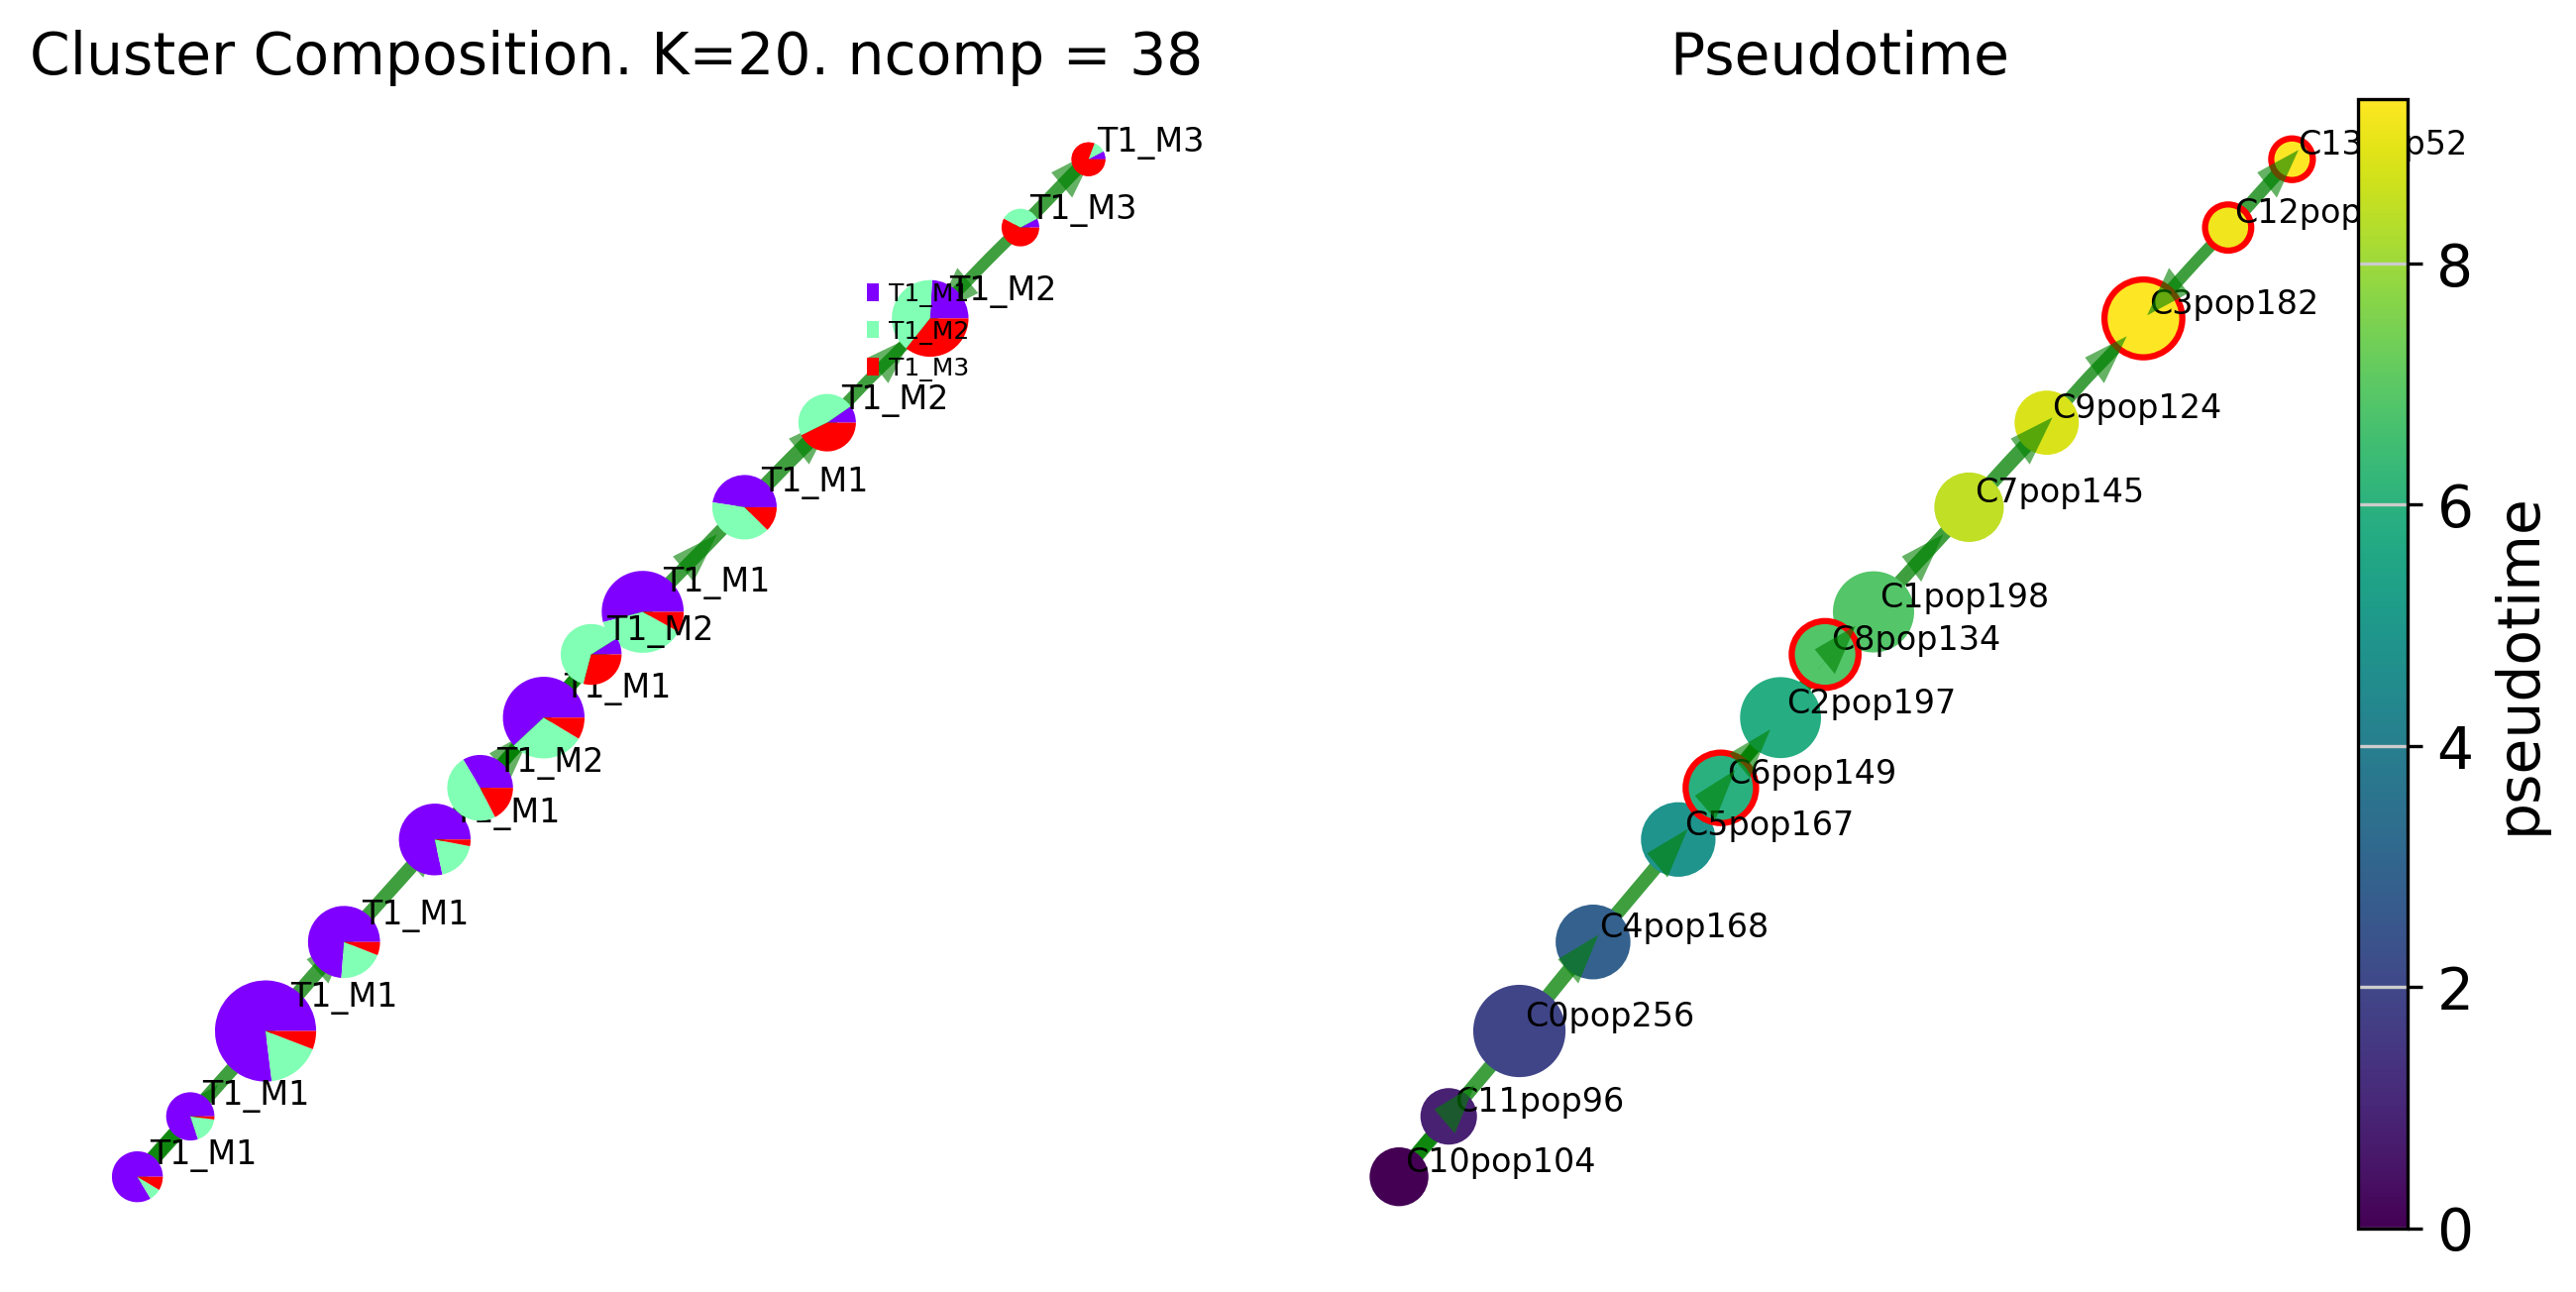

In [29]:
fig, ax, ax2= via.draw_piechart_graph(via_object=v0, cmap='viridis', ax_text=True, alpha_edge=0.5, linewidth_edge=1.5, edge_color='green', headwidth_arrow=0.2)
fig.set_size_inches(10,5)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |#######################

2023-09-14 17:15:49.573613	Super cluster 3 is a super terminal with sub_terminal cluster 3
2023-09-14 17:15:49.573893	Super cluster 6 is a super terminal with sub_terminal cluster 6
2023-09-14 17:15:49.573914	Super cluster 8 is a super terminal with sub_terminal cluster 8
2023-09-14 17:15:49.573943	Super cluster 12 is a super terminal with sub_terminal cluster 12
2023-09-14 17:15:49.573959	Super cluster 13 is a super terminal with sub_terminal cluster 13


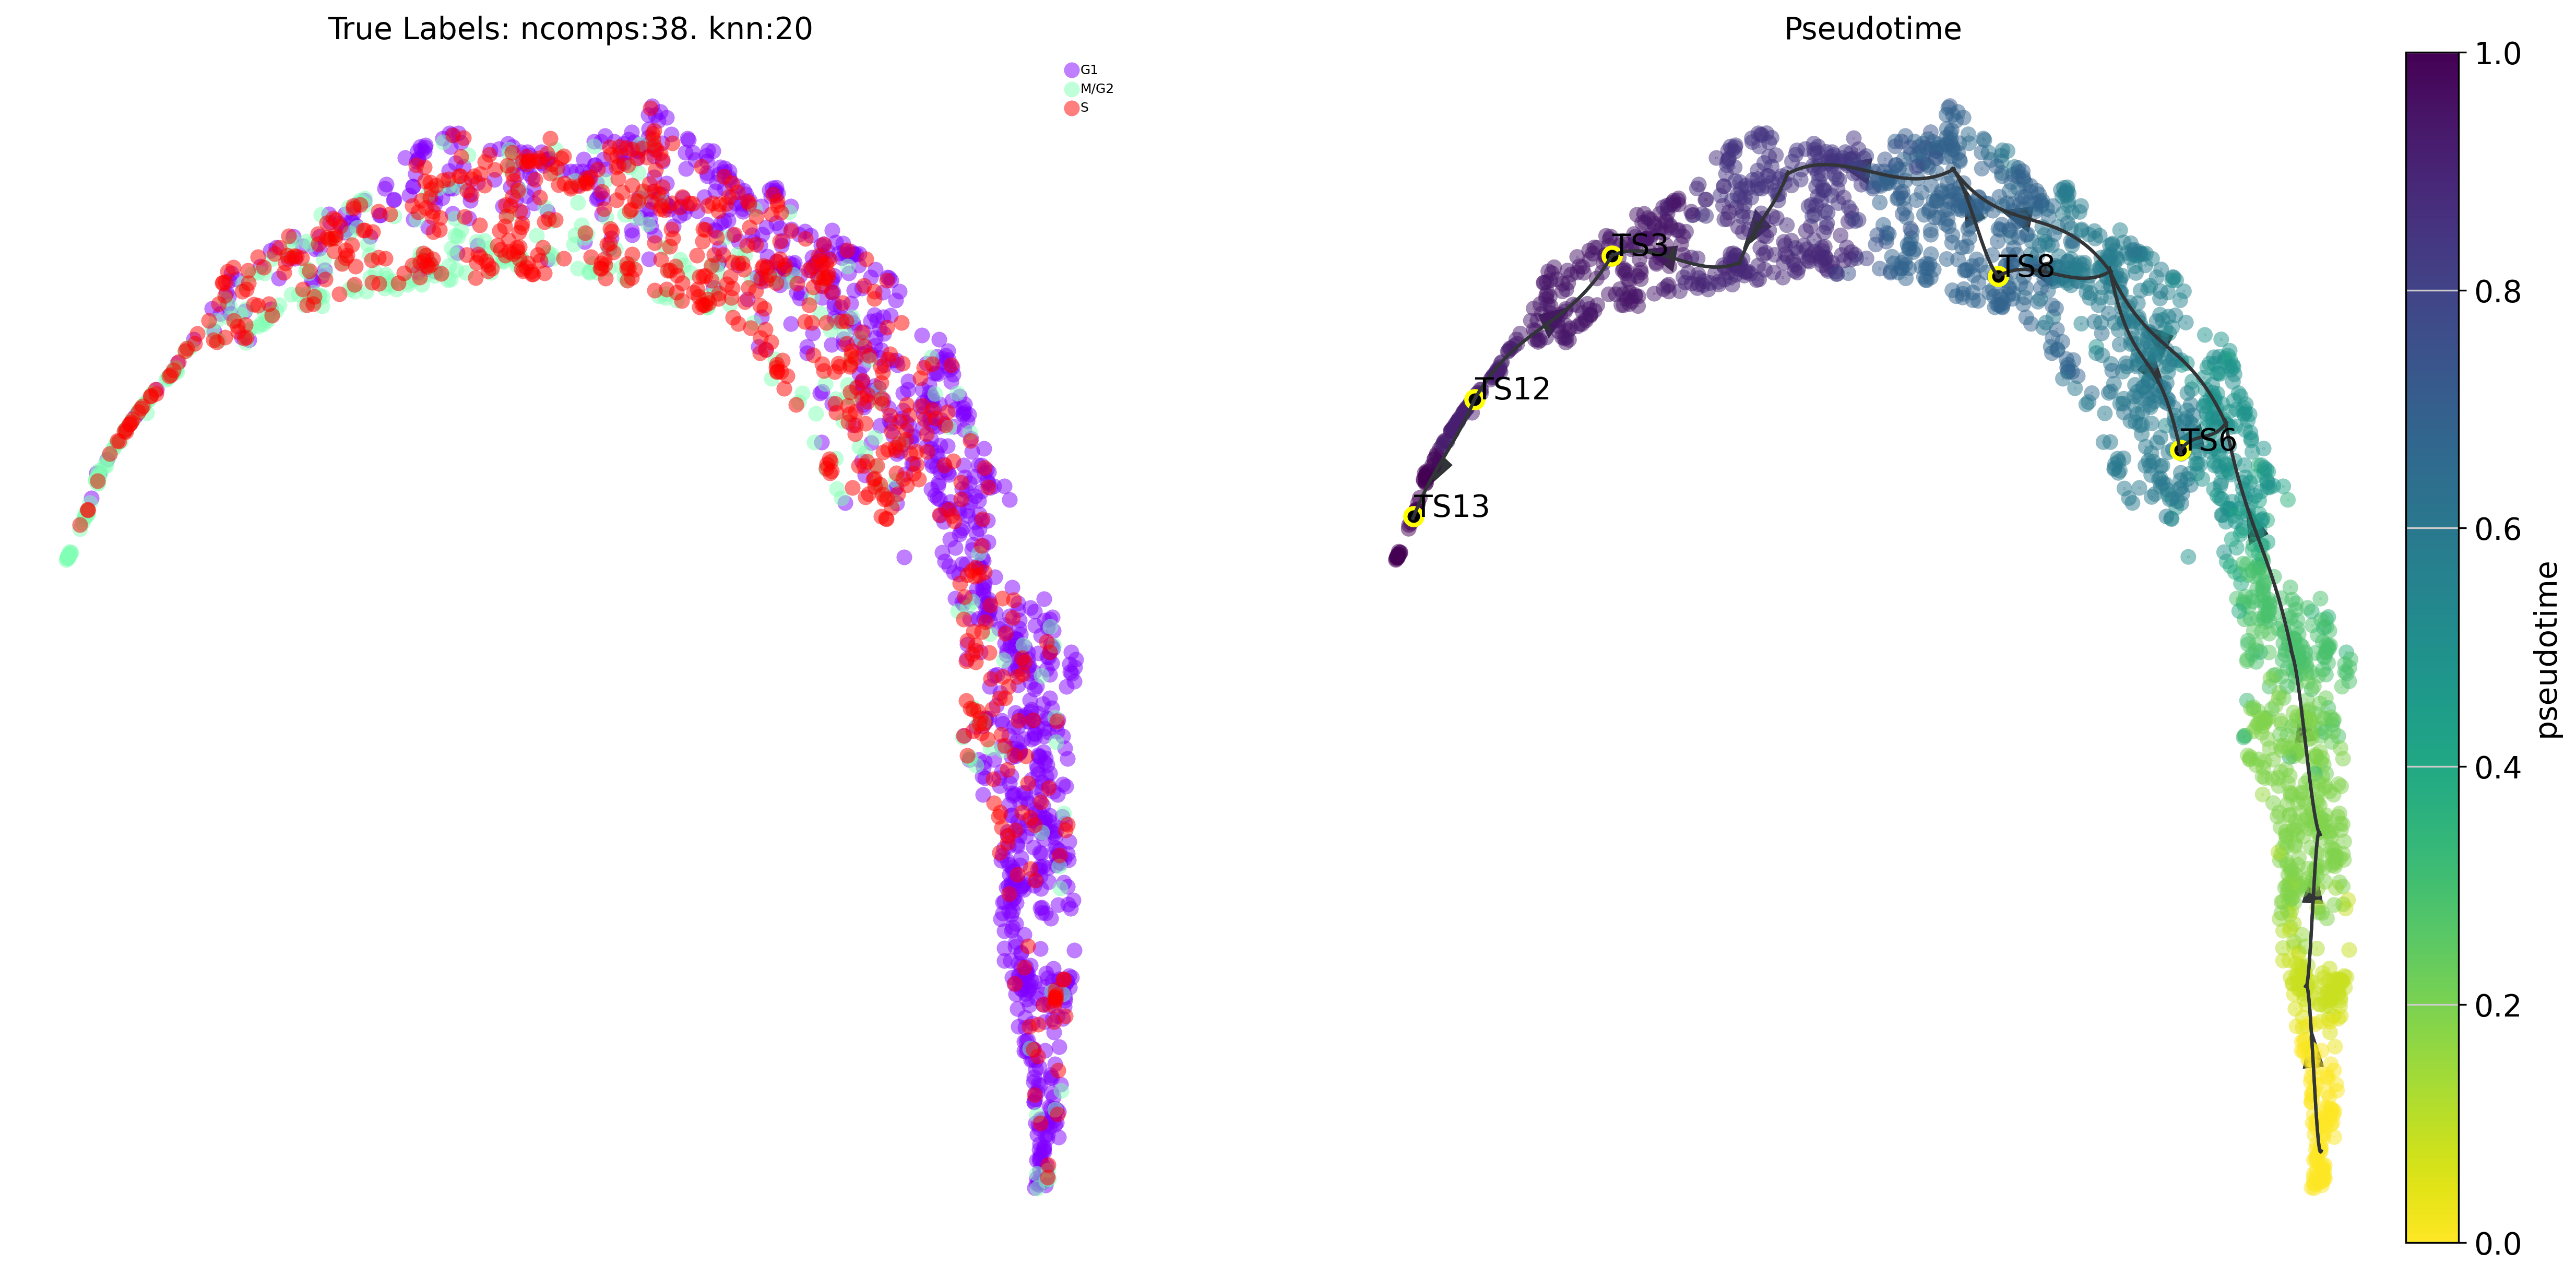

In [9]:
via.draw_trajectory_gams(via_object=v0, embedding=embedding)
plt.show()

### Physical Feature Dynamics

(2036, 8)


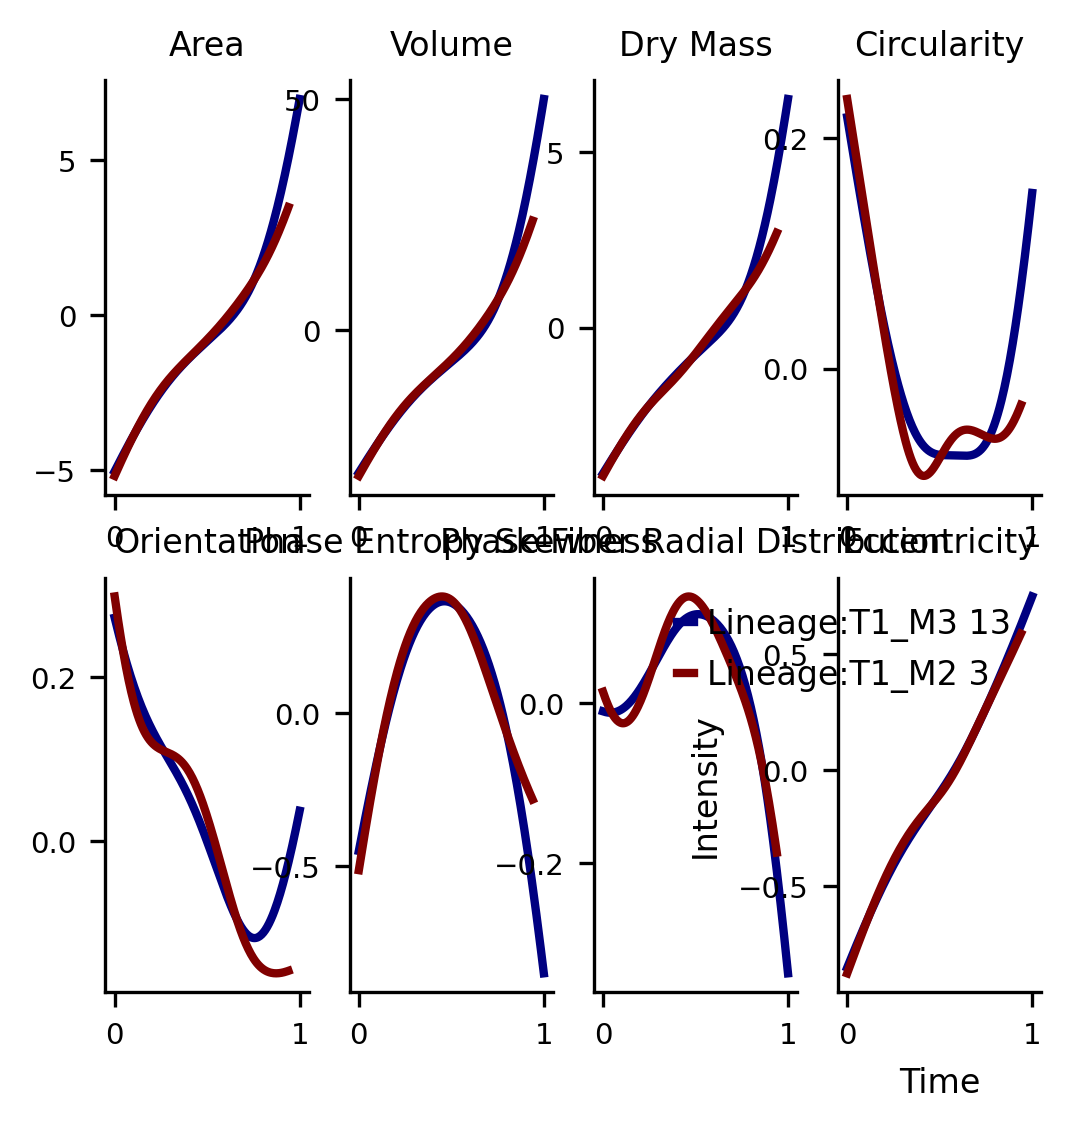

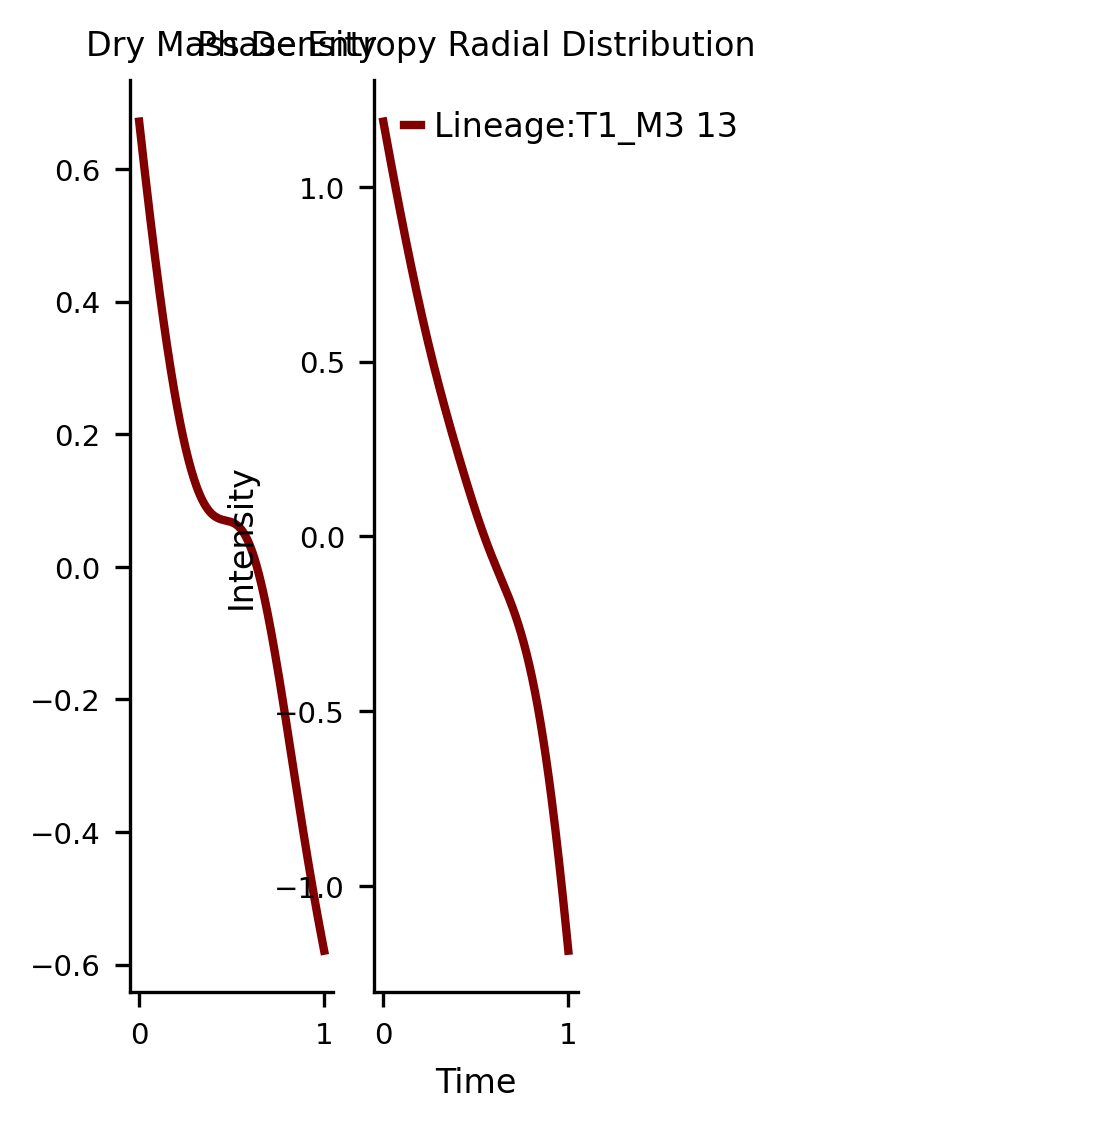

In [27]:
all_cols = ['Area', 'Volume', 'Dry Mass', 'Circularity', 'Orientation', 'Phase Entropy Skewness',
                'Phase Fiber Radial Distribution', 'Eccentricity', 'AspectRatio', 'Dry Mass Density', 'Dry Mass var',
                'Dry Mass Skewness', 'Peak Phase', 'Phase Var', 'Phase Skewness', 'Phase Kurtosis', 'Phase Range',
                'Phase Min', 'Phase Centroid Displacement', 'Phase STD Mean', 'Phase STD Variance',
                'Phase STD Skewness', 'Phase STD Kurtosis', 'Phase STD Centroid Displacement',
                'Phase STD Radial Distribution', 'Phase Entropy Mean', 'Phase Entropy Var', 'Phase Entropy Kurtosis',
                'Phase Entropy Centroid Displacement', 'Phase Entropy Radial Distribution',
                'Phase Fiber Centroid Displacement', 'Phase Fiber Pixel >Upper Percentile', 'Phase Fiber Pixel >Median',
                'Mean Phase Arrangement', 'Phase Arrangement Var', 'Phase Arrangement Skewness',
                'Phase Orientation Var', 'Phase Orientation Kurtosis']

subset_ = pd.DataFrame(ad[:,all_cols[0:8]].X, columns=all_cols[0:8])
print(subset_.shape)

fig,axs =via.get_gene_expression(via_object=v0, gene_exp=subset_, marker_lineages=[13,3])

subset_ = pd.DataFrame(ad[:, ['Dry Mass Density','Phase Entropy Radial Distribution']].X, columns= ['Dry Mass Density','Phase Entropy Radial Distribution'])
fig,axs =via.get_gene_expression(via_object=v0, gene_exp=subset_,marker_lineages=[13])

plt.show()

